In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
from statsmodels.tsa.stattools import coint
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler


In [10]:
# Function to fetch stock data from Yahoo Finance
def fetch_data(ticker, start_date, end_date):
    data = yf.download(ticker, start=start_date, end=end_date, progress=False)['Adj Close']
    return data

# Function to align data based on common dates
def align_data(data1, data2):
    common_dates = data1.index.intersection(data2.index)
    aligned_data1 = data1.loc[common_dates]
    aligned_data2 = data2.loc[common_dates]
    return aligned_data1, aligned_data2

# Function to perform cointegration test
def perform_cointegration_test(data1, data2):
    data1_aligned, data2_aligned = align_data(data1, data2)
    _, pvalue, _ = coint(data1_aligned, data2_aligned)
    return pvalue

# Function to calculate correlation
def calculate_correlation(data1, data2):
    data1_aligned, data2_aligned = align_data(data1, data2)
    correlation = np.corrcoef(data1_aligned, data2_aligned)[0, 1]
    return correlation

# Function to calculate spread
def calculate_spread(data1, data2):
    data1_aligned, data2_aligned = align_data(data1, data2)
    hedge_ratio = np.polyfit(data2_aligned, data1_aligned, 1)[0]
    spread = data1_aligned - hedge_ratio * data2_aligned
    return spread, hedge_ratio

# Function to calculate z-score of the spread
def calculate_zscore(spread):
    zscore = (spread - spread.mean()) / spread.std()
    return zscore


In [ ]:
# Function to select cointegrated and correlated pairs
def select_cointegrated_and_correlated_pairs(data_dict, cointegration_threshold=0.05, correlation_threshold=0.7):
    cointegrated_and_correlated_pairs = []
    p_values = {}
    correlations = {}
    
    for ticker1, data1 in data_dict.items():
        for ticker2, data2 in data_dict.items():
            if ticker1 != ticker2:
                coint_pvalue = perform_cointegration_test(data1, data2)
                correlation_value = calculate_correlation(data1, data2)
                
                p_values[(ticker1, ticker2)] = coint_pvalue
                correlations[(ticker1, ticker2)] = correlation_value
                
                if coint_pvalue < cointegration_threshold and abs(correlation_value) > correlation_threshold:
                    cointegrated_and_correlated_pairs.append((ticker1, ticker2))
    
    unique_pairs = []
    for pair in cointegrated_and_correlated_pairs:
        if (pair[1], pair[0]) not in unique_pairs:
            unique_pairs.append(pair)
    
    sorted_pairs = sorted(unique_pairs, key=lambda x: (p_values[x], abs(correlations[x])), reverse=True)
    top_3_pairs = sorted_pairs[:3]
    
    return top_3_pairs, p_values, correlations


In [11]:
# Function to execute trades based on z-score strategy
def execute_zscore_trades(pair, data1, data2, spread, zscore, entry_threshold=0.9, exit_threshold=0.4):
    trades = []
    pnl = []
    position = None
    trading_capital = 10000
    
    for i in range(len(spread)):
        if zscore[i] < -entry_threshold:
            if position != 'Long':
                position = 'Long'
                entry_price1 = data1.iloc[i]
                entry_price2 = data2.iloc[i]
                shares_bought = int(trading_capital / entry_price1)
                shares_sold = int(trading_capital / entry_price2)
                trades.append(('Long', spread.index[i], entry_price1, shares_bought, entry_price2, shares_sold, None, None, None))
        elif zscore[i] > entry_threshold:
            if position != 'Short':
                position = 'Short'
                entry_price1 = data1.iloc[i]
                entry_price2 = data2.iloc[i]
                shares_bought = int(trading_capital / entry_price2)
                shares_sold = int(trading_capital / entry_price1)
                trades.append(('Short', spread.index[i], entry_price1, shares_sold, entry_price2, shares_bought, None, None, None))
        elif abs(zscore[i]) < exit_threshold:
            if position:
                exit_price1 = data1.iloc[i]
                exit_price2 = data2.iloc[i]
                if position == 'Long':
                    trade_pnl = (exit_price1 - trades[-1][2]) * trades[-1][3] + (trades[-1][4] - exit_price2) * trades[-1][5]
                elif position == 'Short':
                    trade_pnl = (trades[-1][2] - exit_price1) * trades[-1][3] + (exit_price2 - trades[-1][4]) * trades[-1][5]
                pnl.append(trade_pnl)
                trades[-1] = (trades[-1][0], trades[-1][1], trades[-1][2], trades[-1][3], trades[-1][4], trades[-1][5], spread.index[i], (exit_price1, exit_price2), (trade_pnl / trading_capital) * 100)
                position = None
    
    returns = [(p / trading_capital) * 100 for p in pnl]
    
    return pnl, returns, trades



In [12]:
# Function to calculate drawdown series
def calculate_drawdown(returns):
    cumulative_returns = np.cumsum(returns)
    peak = np.maximum.accumulate(cumulative_returns)
    drawdown = peak - cumulative_returns
    max_drawdown = np.max(drawdown)
    return drawdown, max_drawdown


In [13]:
# Function to cluster stocks using PCA and DBSCAN
def cluster_stocks(data_dict):
    prices = pd.DataFrame(data_dict)
    returns = prices.pct_change().dropna()
    scaler = StandardScaler()
    scaled_returns = scaler.fit_transform(returns)
    
    pca = PCA(n_components=2)
    pca_result = pca.fit_transform(scaled_returns)
    
    dbscan = DBSCAN(eps=0.5, min_samples=5)
    clusters = dbscan.fit_predict(pca_result)
    
    cluster_dict = {}
    for i, ticker in enumerate(prices.columns):
        cluster = clusters[i]
        if cluster not in cluster_dict:
            cluster_dict[cluster] = []
        cluster_dict[cluster].append(ticker)
    
    return cluster_dict


Stock Prices:
            AXISBANK.NS  BANKBARODA.NS  FEDERALBNK.NS  HDFCBANK.NS  \
Date                                                                 
2015-01-01   487.755188     198.187592      68.452034   440.343445   
2015-01-02   498.663147     200.603073      67.950371   446.471832   
2015-01-05   501.814331     200.548172      67.403122   442.702301   
2015-01-06   483.876831     193.878174      66.445435   435.810669   
2015-01-07   483.488922     195.195679      66.650642   437.082672   
...                 ...            ...            ...          ...   
2019-12-24   738.770508      94.172539      82.854851  1237.556396   
2019-12-26   734.630981      93.371269      82.854851  1219.604736   
2019-12-27   758.221008      98.273140      85.321625  1223.972656   
2019-12-30   752.186279      97.000542      84.692848  1230.836670   
2019-12-31   752.186279      96.057877      85.079796  1221.188721   

            ICICIBANK.NS  KOTAKBANK.NS     SBIN.NS  UNIONBANK.NS  
Date    

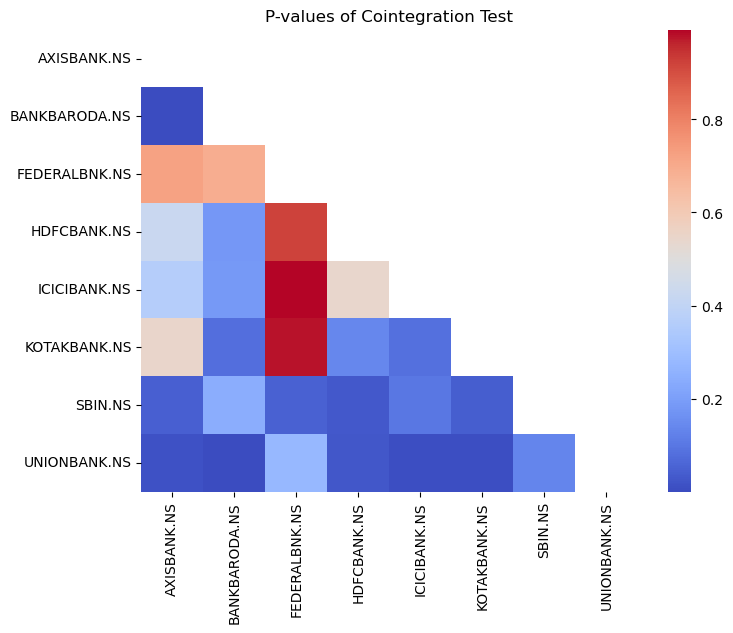


Trades for pair SBIN.NS and FEDERALBNK.NS:
   Position Entry Date  Entry Price 1  Shares 1  Entry Price 2  Shares 2  \
0     Short 2015-01-01     285.500397        35      68.452034       146   
1     Short 2015-04-06     249.721924        40      59.376778       168   
2     Short 2015-08-03     258.766998        38      62.703167       159   
3     Short 2015-08-17     257.570068        38      62.703167       159   
4      Long 2016-01-15     169.687820        58      44.410885       225   
5      Long 2017-05-02     268.928680        37     105.334419        94   
6      Long 2017-05-24     264.124725        37     100.465622        99   
7      Long 2017-08-11     263.689606        37      99.715988       100   
8     Short 2018-01-24     310.516541        32      97.450783       102   
9      Long 2018-03-01     246.747208        40      88.720329       112   
10    Short 2018-08-06     290.373901        34      84.446045       118   
11    Short 2018-08-17     284.349945       

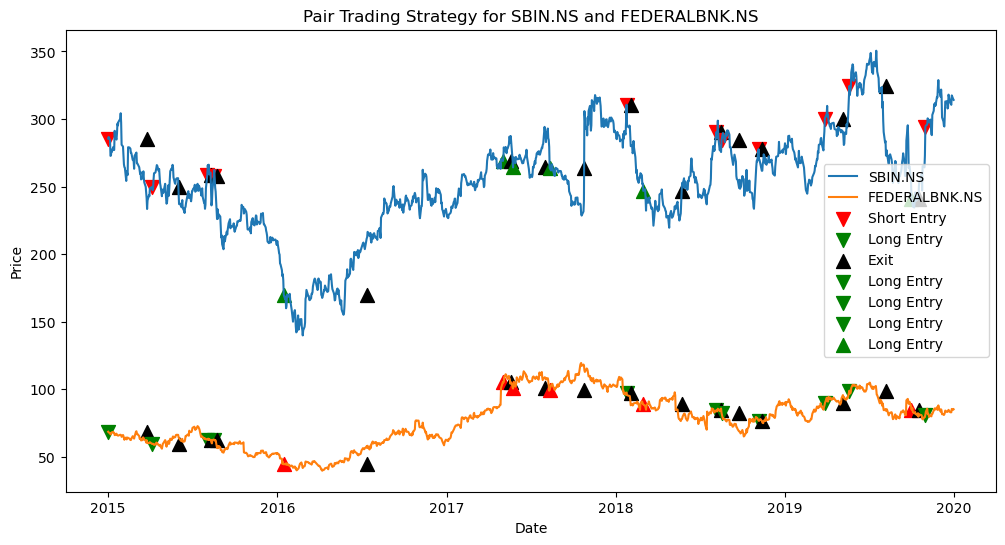

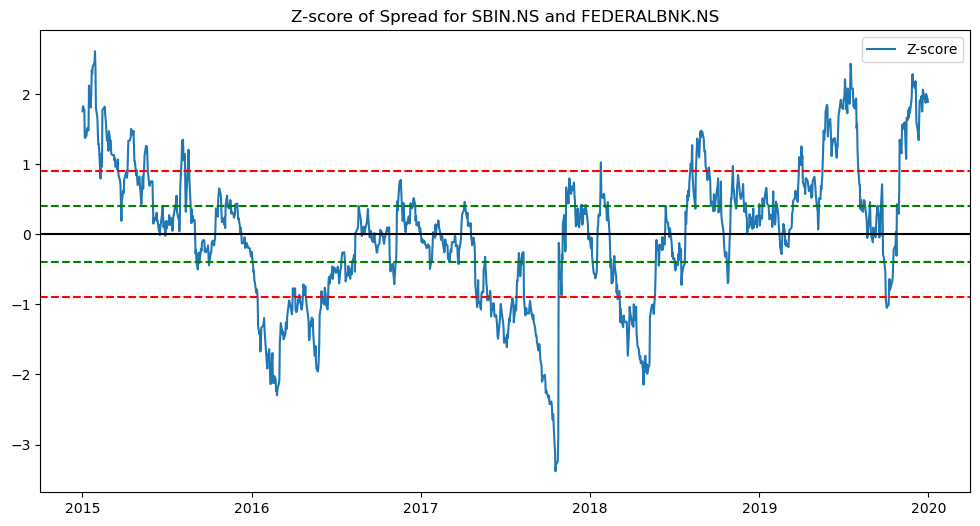


Trades for pair SBIN.NS and AXISBANK.NS:
   Position Entry Date  Entry Price 1  Shares 1  Entry Price 2  Shares 2  \
0     Short 2015-01-01     285.500397        35     487.755188        20   
1     Short 2015-02-16     278.862976        35     552.960510        18   
2      Long 2016-01-15     169.687820        58     365.789185        27   
3     Short 2016-11-10     262.398987        38     500.122589        19   
4     Short 2016-12-09     248.733368        40     450.253326        22   
5     Short 2017-02-02     254.936539        39     476.051147        21   
6     Short 2017-03-24     257.921539        38     482.759583        20   
7     Short 2017-10-25     305.810272        32     471.214447        21   
8     Short 2018-07-31     276.255219        36     548.322266        18   
9      Long 2019-02-01     267.689880        37     714.542419        13   
10    Short 2019-07-05     348.872192        28     804.054260        12   
11     Long 2019-08-22     252.771133        3

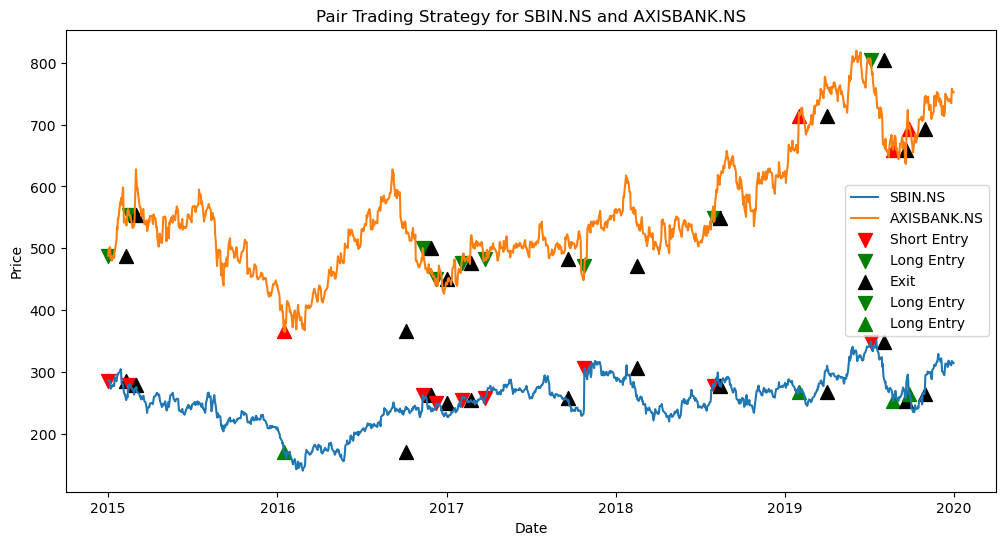

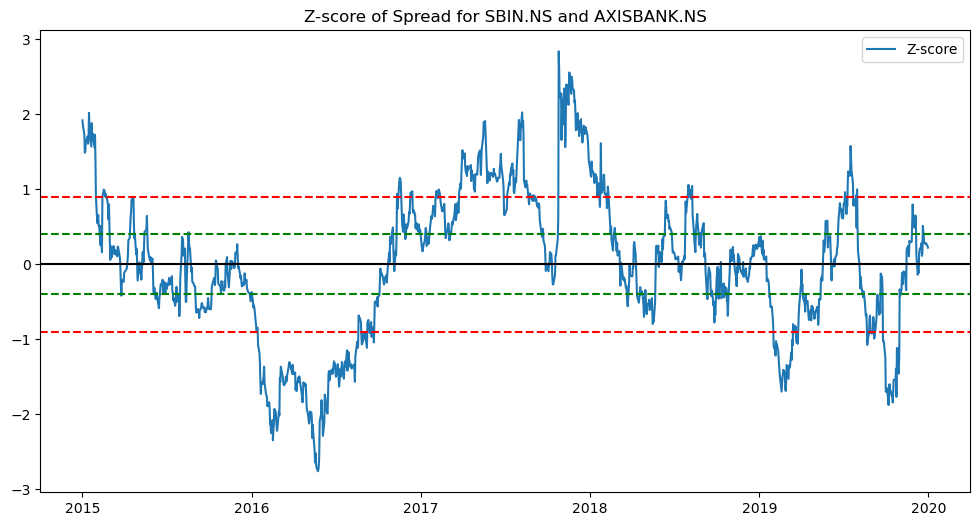


Trades for pair UNIONBANK.NS and HDFCBANK.NS:
   Position Entry Date  Entry Price 1  Shares 1  Entry Price 2  Shares 2  \
0     Short 2015-01-01     208.797928        47     440.343445        22   
1      Long 2015-04-27     123.772179        80     465.042084        21   
2      Long 2015-06-11     122.819756        81     462.613831        21   
3     Short 2015-08-03     168.157776        59     510.454010        19   
4     Short 2015-10-05     164.593384        60     511.828613        19   
5      Long 2016-01-07     122.317070        81     492.186829        20   
6      Long 2016-08-11     113.463882        88     577.059509        17   
7      Long 2016-12-22     115.709328        86     551.148743        18   
8     Short 2017-02-03     153.332062        65     615.960815        16   
9     Short 2017-03-20     144.625198        69     674.712097        14   
10     Long 2018-03-23      79.598854       125     870.950684        11   
11     Long 2018-09-18      68.600739    

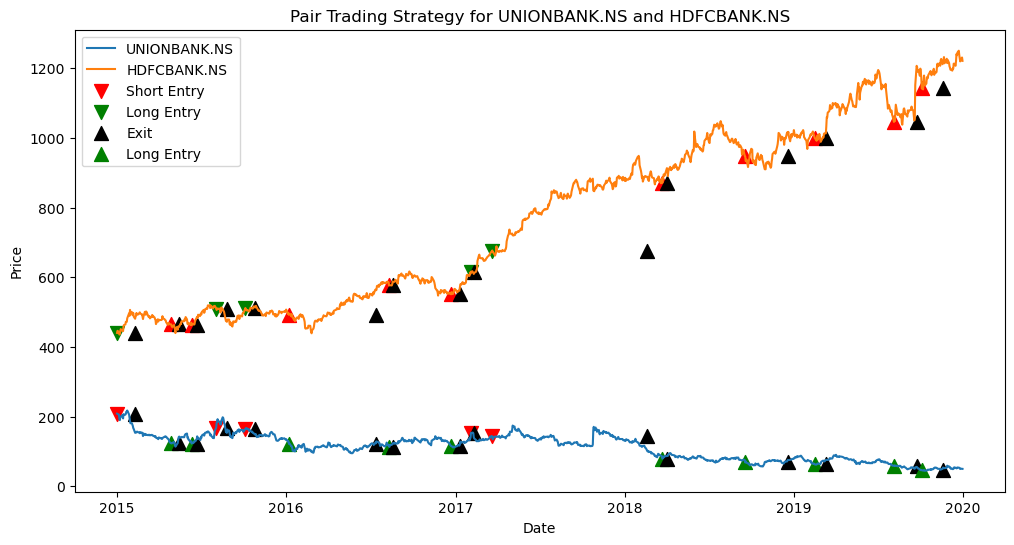

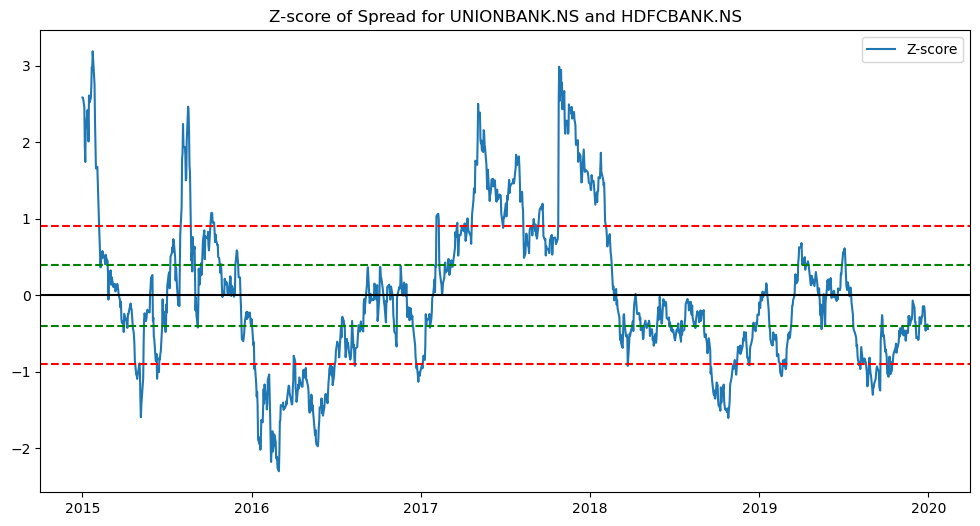

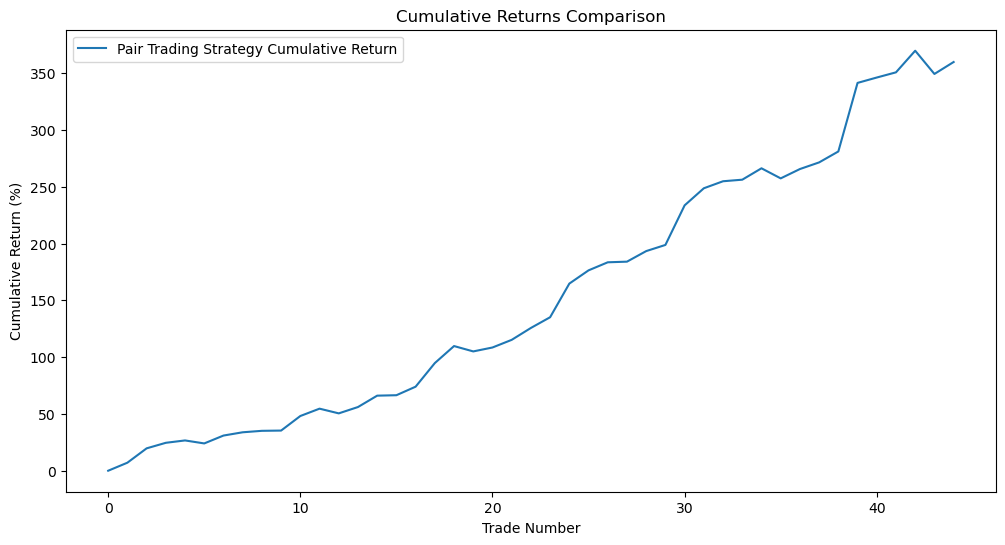


Total return for each pair:
SBIN.NS and FEDERALBNK.NS: 73.97%
SBIN.NS and AXISBANK.NS: 124.76%
UNIONBANK.NS and HDFCBANK.NS: 161.02%
Overall strategy return: 359.76%
Bank Nifty return over the same period: 61.90%
Maximum Drawdown: 20.45%


In [15]:
# Main function to execute the complete strategy
def main():
    tickers = ['AXISBANK.NS' , 'BANKBARODA.NS', 'FEDERALBNK.NS', 'HDFCBANK.NS', 'ICICIBANK.NS',
               'KOTAKBANK.NS' , 'SBIN.NS' ,'UNIONBANK.NS']
    start_date = '2015-01-01'
    end_date = '2020-01-01'

    data_dict = {}
    for ticker in tickers:
        data = fetch_data(ticker, start_date, end_date)
        data_dict[ticker] = data

    # Fetch Bank Nifty data
    bank_nifty_data = fetch_data('^NSEBANK', start_date, end_date)
    bank_nifty_returns = bank_nifty_data.pct_change().dropna()

    stock_prices_df = pd.DataFrame(data_dict)
    print("Stock Prices:")
    print(stock_prices_df)

    cluster_dict = cluster_stocks(data_dict)
    print("Clustered Stocks:")
    print(cluster_dict)

    top_3_pairs, p_values, correlations = select_cointegrated_and_correlated_pairs(data_dict)
    if top_3_pairs:
        print("\nHigh Cointegrated and Correlated pairs:")
        for pair in top_3_pairs:
            print(pair)
            print("Cointegration p-value:", p_values[pair])
            print("Correlation:", correlations[pair])
    else:
        print("\nNo cointegrated and correlated pairs found among the entered stocks.")

    p_values_df = pd.DataFrame(index=tickers, columns=tickers, dtype=float)
    for pair, p_value in p_values.items():
        p_values_df.loc[pair[0], pair[1]] = p_value

    mask = np.triu(np.ones_like(p_values_df, dtype=bool))
    plt.figure(figsize=(8, 6))
    sns.heatmap(p_values_df, mask=mask, cmap="coolwarm", annot=False, fmt=".4f")
    plt.title("P-values of Cointegration Test")
    plt.show()

    overall_pnl_zscore = []
    overall_returns_zscore = []
    pair_returns = {}

    for pair in top_3_pairs:
        stock1 = data_dict[pair[0]]
        stock2 = data_dict[pair[1]]
        spread, hedge_ratio = calculate_spread(stock1, stock2)
        zscore = calculate_zscore(spread)

        pnl_zscore, returns_zscore, trades_zscore = execute_zscore_trades(pair, stock1, stock2, spread, zscore)
        overall_pnl_zscore.extend(pnl_zscore)
        overall_returns_zscore.extend(returns_zscore)

        total_return = np.sum(returns_zscore)
        pair_returns[pair] = total_return

        trade_df_zscore = pd.DataFrame(trades_zscore, columns=['Position', 'Entry Date', 'Entry Price 1', 'Shares 1', 'Entry Price 2', 'Shares 2', 'Exit Date', 'Exit Prices', 'Trade Return (%)'])
        print(f"\nTrades for pair {pair[0]} and {pair[1]}:")
        print(trade_df_zscore)

        plt.figure(figsize=(12, 6))
        plt.plot(stock1, label=pair[0])
        plt.plot(stock2, label=pair[1])
        long_entry_plotted = short_entry_plotted = exit_plotted = False

        for trade in trades_zscore:
            if trade[0] == 'Long':
                plt.scatter(trade[1], trade[2], color='green', marker='^', s=100, label='Long Entry' if not long_entry_plotted else "")
                plt.scatter(trade[1], trade[4], color='red', marker='^', s=100, label='Short Entry' if not short_entry_plotted else "")
                long_entry_plotted = True
            elif trade[0] == 'Short':
                plt.scatter(trade[1], trade[2], color='red', marker='v', s=100, label='Short Entry' if not short_entry_plotted else "")
                plt.scatter(trade[1], trade[4], color='green', marker='v', s=100, label='Long Entry' if not long_entry_plotted else "")
                short_entry_plotted = True
            if trade[6]:
                plt.scatter(trade[6], trade[2], color='black', marker='^', s=100, label='Exit' if not exit_plotted else "")
                plt.scatter(trade[6], trade[4], color='black', marker='^', s=100)
                exit_plotted = True

        plt.legend()
        plt.title(f"Pair Trading Strategy for {pair[0]} and {pair[1]}")
        plt.xlabel("Date")
        plt.ylabel("Price")
        plt.show()

        plt.figure(figsize=(12, 6))
        plt.plot(zscore, label='Z-score')
        plt.axhline(0.9, color='r', linestyle='--')
        plt.axhline(-0.9, color='r', linestyle='--')
        plt.axhline(0.4, color='g', linestyle='--')
        plt.axhline(-0.4, color='g', linestyle='--')
        plt.axhline(0, color='black', linestyle='-')
        plt.title(f"Z-score of Spread for {pair[0]} and {pair[1]}")
        plt.legend()
        plt.show()

    # Compare strategy returns with Bank Nifty
    cumulative_returns_zscore = np.cumsum(overall_returns_zscore)
    cumulative_returns_zscore = np.insert(cumulative_returns_zscore, 0, 0)  # Insert 0 at the beginning for plotting

    drawdown_series, max_drawdown = calculate_drawdown(overall_returns_zscore)

    plt.figure(figsize=(12, 6))
    plt.plot(cumulative_returns_zscore, label='Pair Trading Strategy Cumulative Return')
    plt.legend()
    plt.title("Cumulative Returns Comparison")
    plt.xlabel("Trade Number")
    plt.ylabel("Cumulative Return (%)")
    plt.show()

    # Print total returns for each pair
    print("\nTotal return for each pair:")
    for pair, total_return in pair_returns.items():
        print(f"{pair[0]} and {pair[1]}: {total_return:.2f}%")
        
    # Calculate and print Sharpe Ratio and Maximum Drawdown
    print(f"Overall strategy return: {np.sum(overall_returns_zscore):.2f}%")
    print(f"Bank Nifty return over the same period: {bank_nifty_returns.cumsum()[-1] * 100:.2f}%")
    print(f"Maximum Drawdown: {max_drawdown:.2f}%")



if __name__ == "__main__":
    main()